In [1]:
#Instalando as bibliotecas que precisamos
!pip install gcsfs pandas
!pip install gcsfs openpyxl pandas

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [2]:
#Importando as biblotecas que usarei
from google.cloud import storage 
import pandas as pd
import gcsfs
from google.cloud import bigquery

In [3]:
#Validando que estou loggeada no projeto correto
project = !gcloud config get-value project
PROJECT_ID = project[0]
print(PROJECT_ID)

#====================CONFIGURARAÇÃO DAS VARIÁVEIS ========================
#Especificando o bucket do projeto onde estão os csv dos dados que usarei
bucket_name = 'dadosprojetopucrj'
file_path_tabela_hotel = 'hotel.csv'
file_path_tabela_reserva = 'reservas.csv'

# Configura tu cliente de BigQuery onde está o dataset onde farei a carga dos dados dos hoteis e reservas
client = bigquery.Client()
project_id = PROJECT_ID
dataset_id = 'datasethotels' #Dataset de Bigquery
table_hotel_id = 'hotels'    #Tala de BigQuery de hoteles
table_reserva_id = 'reserva' #Tala de BigQuery de reservas
table_ref_hotel = f'{project_id}.{dataset_id}.{table_hotel_id}' #Nome completo da tabela a nivel de codigo
table_ref_reserva = f'{project_id}.{dataset_id}.{table_reserva_id}' #Nome completo da tabela a nivel de codigo

brilliant-will-428421-k1


In [4]:
#Começando a carga de dados por hotel

# Rota do arquivo em Google Cloud Storage (GCS)
gcs_file_path_hotel = f'gs://{bucket_name}/{file_path_tabela_hotel}'

# Ler o arquivo CSV desde GCS
df_hotel = pd.read_csv(gcs_file_path_hotel)

# Mostrar las primeras 3 filas del DataFrame onde da para ver que existem valores faltantes (NaN)
print(df_hotel.head(3))

               Hotel Names  Star Rating  Rating Free Parking Fitness Centre  \
0   Yerevan Resident Hotel          5.0     7.1          Yes             No   
1  Mario in New York Hotel          5.0     5.0          Yes            Yes   
2         Avan Plaza Hotel          NaN     8.4          Yes             No   

  Spa and Wellness Centre Airport Shuttle  Staff  Facilities  Location  \
0                      No             Yes    8.0         7.3       8.9   
1                     Yes              No    7.5         2.5       7.5   
2                      No              No    8.8         8.4       7.8   

   Comfort  Cleanliness  Price Per Day($)  
0      7.7          7.5             150.0  
1      5.0          5.0             110.0  
2      8.6          8.4             112.5  


In [5]:
#Codificando as colunas que tomam valores Yes/No em valores numéricos 1/0
df_hotel['Free Parking'] = df_hotel['Free Parking'].apply(lambda x: 1 if x == 'Yes' else 0)
df_hotel['Fitness Centre'] = df_hotel['Fitness Centre'].apply(lambda x: 1 if x == 'Yes' else 0)
df_hotel['Spa and Wellness Centre'] = df_hotel['Spa and Wellness Centre'].apply(lambda x: 1 if x == 'Yes' else 0)
df_hotel['Airport Shuttle'] = df_hotel['Airport Shuttle'].apply(lambda x: 1 if x == 'Yes' else 0)
    
#Completando valores faltantes com a função fillna() de pandas
for column in ['Star Rating', 'Rating', 'Staff', 'Facilities', 'Location', 'Comfort', 'Cleanliness']:
    df_hotel[column].fillna(df_hotel[column].median(), inplace=True)

#Revisando os dados transformados com a função describe que cria um resumo estatisco dos dados    
df_hotel.describe()    

,Star Rating,Rating,Free Parking,Fitness Centre,Spa and Wellness Centre,Airport Shuttle,Staff,Facilities,Location,Comfort,Cleanliness,Price Per Day($)
count,100.000000,100.000000,100.000000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.870000,8.848000,0.650000,0.21000,0.15000,0.780000,9.292000,8.821000,8.932000,9.000000,8.998000,84.050000
std,0.580056,0.758851,0.479372,0.40936,0.35887,0.416333,0.509045,0.915335,0.823258,0.731679,0.765279,64.901693
min,2.000000,5.000000,0.000000,0.00000,0.00000,0.000000,7.500000,2.500000,7.000000,5.000000,5.000000,6.000000
25%,4.000000,8.500000,0.000000,0.00000,0.00000,1.000000,9.100000,8.600000,8.375000,8.800000,8.800000,45.000000
50%,4.000000,9.000000,1.000000,0.00000,0.00000,1.000000,9.400000,9.000000,9.100000,9.100000,9.100000,75.500000
75%,4.000000,9.300000,1.000000,0.00000,0.00000,1.000000,9.625000,9.300000,9.700000,9.400000,9.400000,112.625000
max,5.000000,10.000000,1.000000,1.00000,1.00000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,525.000000


In [6]:
# Renomeando as colunas usando boas praticas de desenvolvimento de código
# Os nomes não devem ter espaços em branco, carateres especiais, nem letras maiusculas

df_hotel.rename(columns={
    'Hotel Names': 'hotel_name',
    'Star Rating': 'star_rating',
    'Rating': 'rating',
    'Free Parking': 'free_parking',
    'Fitness Centre': 'fitness_centre',
    'Spa and Wellness Centre': 'spa_and_wellness_centre',
    'Airport Shuttle': 'airport_shuttle',
    'Staff': 'staff_rating',
    'Facilities': 'facilities_rating',
    'Location': 'location_rating',
    'Comfort': 'comfort_rating',
    'Cleanliness': 'cleanliness_rating',
    'Price Per Day($)': 'price_per_day'
}, inplace=True)


#Carregando os dados numa tabela no Datawarehouse (Bigquery estou usando)
ob = client.load_table_from_dataframe(df_hotel, table_ref_hotel)

# Esperar a que el trabajo se complete
ob.result()
df_hotel

,hotel_name,star_rating,rating,free_parking,fitness_centre,spa_and_wellness_centre,airport_shuttle,staff_rating,facilities_rating,location_rating,comfort_rating,cleanliness_rating,price_per_day
0,Yerevan Resident Hotel,5.0,7.1,1,0,0,1,8.0,7.3,8.9,7.7,7.5,150.0
1,Mario in New York Hotel,5.0,5.0,1,1,1,0,7.5,2.5,7.5,5.0,5.0,110.0
2,Avan Plaza Hotel,4.0,8.4,1,0,0,0,8.8,8.4,7.8,8.6,8.4,112.5
3,Vicky’s Corner,4.0,9.0,1,0,0,1,9.4,9.0,9.1,9.1,9.1,136.0
4,Cozy & Nice Villa Near Rio Mall,4.0,9.0,1,0,0,1,9.4,9.0,9.1,9.1,9.1,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Radisson BLU Hotel Yerevan,5.0,8.5,1,1,1,1,8.8,8.7,8.4,8.8,8.8,118.0
96,Bourbon Boutique Hotel,3.0,9.1,0,0,0,1,9.4,9.2,9.6,9.4,9.4,102.0
97,Messier 53 Hotel Yerevan,4.0,8.9,1,1,1,1,9.2,9.0,9.1,9.1,9.1,118.0
98,Vertoni Hotel Yerevan,4.0,9.5,0,0,0,1,9.7,9.5,8.3,9.7,9.7,50.0


In [7]:
#Adicionando tabela reservas
# Rota do arquivo em Google Cloud Storage (GCS)
gcs_file_path_reserva = f'gs://{bucket_name}/{file_path_tabela_reserva}'

# Ler o arquivo CSV desde GCS
df_reserva = pd.read_csv(gcs_file_path_reserva)

# Mostrar las primeras 3 filas del DataFrame onde da para ver que no existem valores faltantes (NaN)
df_reserva.loc[df_reserva['hotel_id'] == 0, 'hotel_id'] = 100
print(df_reserva.head(3))

   Unnamed: 0  reserva_id  hotel_id  cliente_id fecha_reserva fecha_checkin  \
0           0           0        37         149    2020-02-25    2020-03-23   
1           1           1        16         996    2021-04-16    2023-09-18   
2           2           2        82         134    2022-11-16    2023-01-29   

  fecha_checkout  monto_total estado_reserva  
0     2020-03-24          892     confirmada  
1     2024-04-15         6199      pendiente  
2     2023-01-30         6918      pendiente  


In [8]:
df_reserva.describe()

,Unnamed: 0,reserva_id,hotel_id,cliente_id,monto_total
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,2499.500000,51.708400,501.072800,4975.095000
std,1443.520003,1443.520003,28.890523,291.146637,2886.964051
min,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1249.750000,1249.750000,27.000000,246.000000,2499.000000
50%,2499.500000,2499.500000,52.000000,504.000000,4949.500000
75%,3749.250000,3749.250000,77.000000,757.000000,7468.250000
max,4999.000000,4999.000000,100.000000,1000.000000,9999.000000


In [9]:
#Carregando os dados numa tabela no Datawarehouse (Bigquery estou usando)
job = client.load_table_from_dataframe(df_reserva, table_ref_reserva)

# Esperar a que el trabajo se complete
job.result()

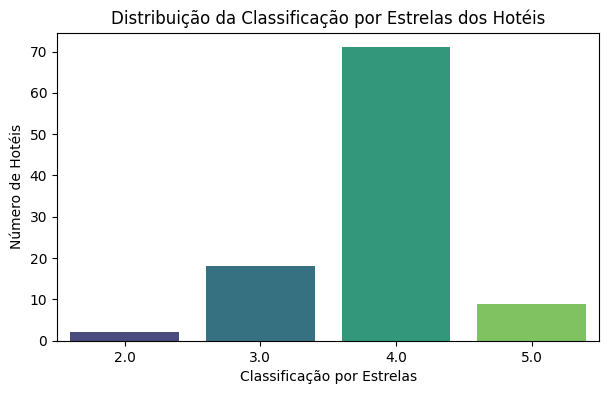

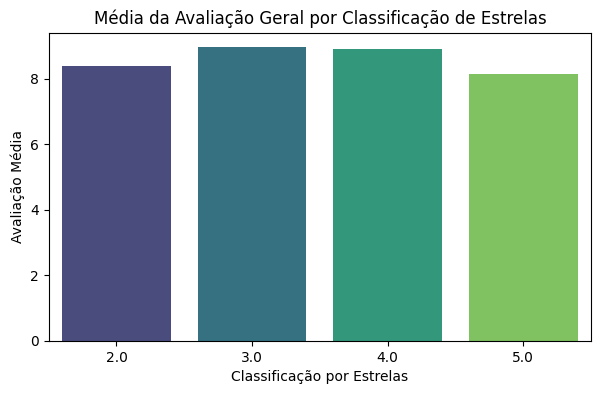

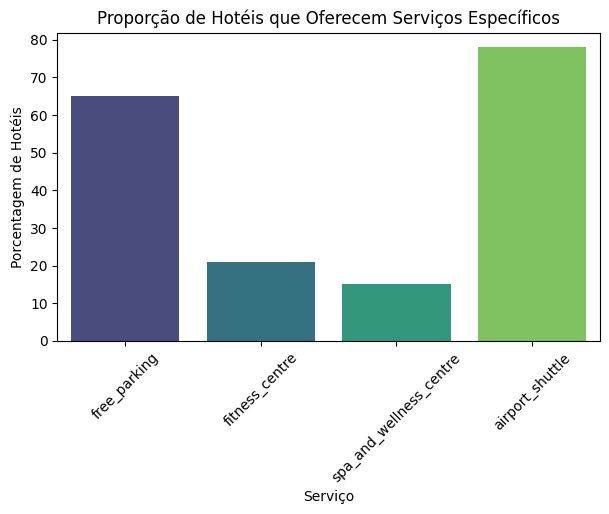

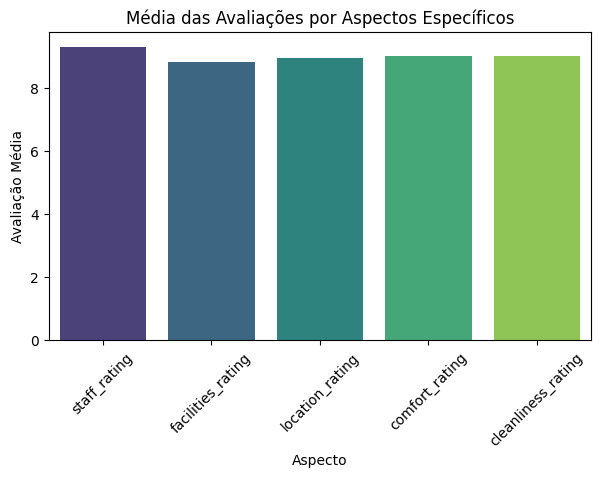

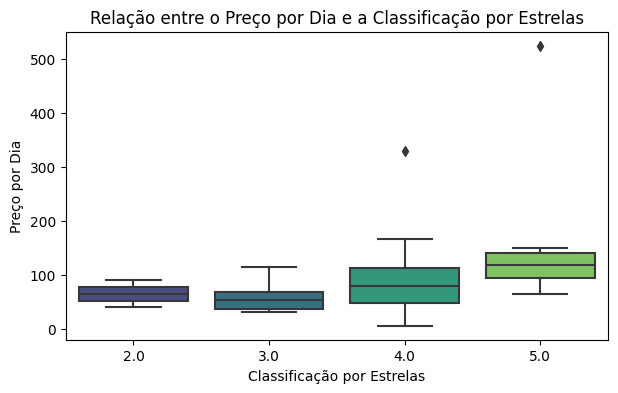

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribuição da classificação por estrelas dos hotéis
plt.figure(figsize=(7, 4))
sns.countplot(x='star_rating', data=df_hotel, palette='viridis')
plt.title('Distribuição da Classificação por Estrelas dos Hotéis')
plt.xlabel('Classificação por Estrelas')
plt.ylabel('Número de Hotéis')
plt.show()

# 2. Média da avaliação geral por classificação de estrelas
avg_rating_by_star = df_hotel.groupby('star_rating')['rating'].mean().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(x='star_rating', y='rating', data=avg_rating_by_star, palette='viridis')
plt.title('Média da Avaliação Geral por Classificação de Estrelas')
plt.xlabel('Classificação por Estrelas')
plt.ylabel('Avaliação Média')
plt.show()

# 3. Proporção de hotéis que oferecem serviços específicos
services = ['free_parking', 'fitness_centre', 'spa_and_wellness_centre', 'airport_shuttle']
service_availability = df_hotel[services].mean().reset_index()
service_availability.columns = ['serviço', 'disponibilidade']
service_availability['disponibilidade'] *= 100  # Convertir a porcentagem

plt.figure(figsize=(7, 4))
sns.barplot(x='serviço', y='disponibilidade', data=service_availability, palette='viridis')
plt.title('Proporção de Hotéis que Oferecem Serviços Específicos')
plt.xlabel('Serviço')
plt.ylabel('Porcentagem de Hotéis')
plt.xticks(rotation=45)
plt.show()

# 4. Média das avaliações de pessoal, instalações, localização, conforto e limpeza
ratings_columns = ['staff_rating', 'facilities_rating', 'location_rating', 'comfort_rating', 'cleanliness_rating']
avg_ratings = df_hotel[ratings_columns].mean().reset_index()
avg_ratings.columns = ['aspecto', 'avaliação_média']

plt.figure(figsize=(7, 4))
sns.barplot(x='aspecto', y='avaliação_média', data=avg_ratings, palette='viridis')
plt.title('Média das Avaliações por Aspectos Específicos')
plt.xlabel('Aspecto')
plt.ylabel('Avaliação Média')
plt.xticks(rotation=45)
plt.show()

# 5. Relação entre o preço por dia e a classificação por estrelas
plt.figure(figsize=(7, 4))
sns.boxplot(x='star_rating', y='price_per_day', data=df_hotel, palette='viridis')
plt.title('Relação entre o Preço por Dia e a Classificação por Estrelas')
plt.xlabel('Classificação por Estrelas')
plt.ylabel('Preço por Dia')
plt.show()



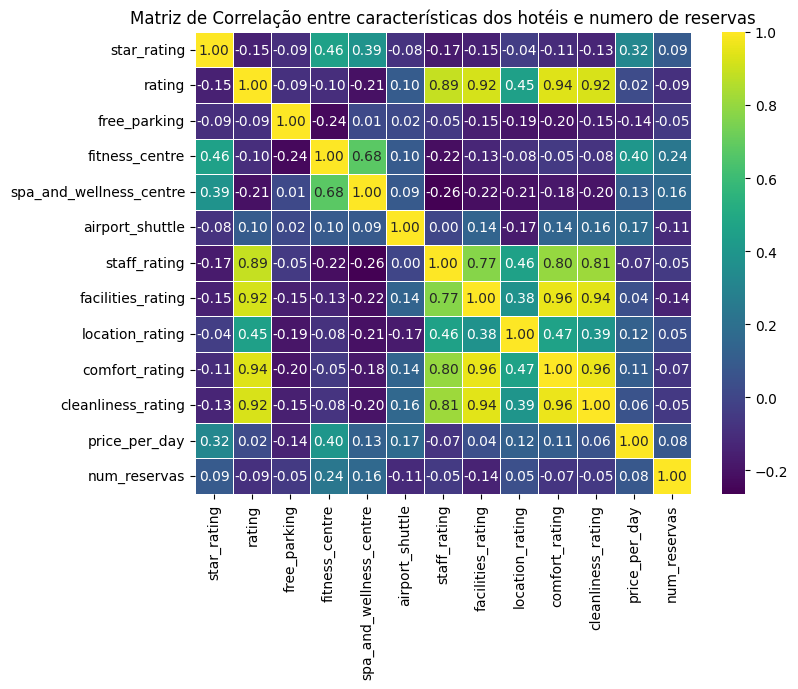

In [11]:
# Crear una instancia de cliente de BigQuery
client = bigquery.Client()

# Definir la consulta
query = '''
    SELECT
        h.hotel_name,
        h.star_rating,
        h.rating,
        h.free_parking,
        h.fitness_centre,
        h.spa_and_wellness_centre,
        h.airport_shuttle,
        h.staff_rating,
        h.facilities_rating,
        h.location_rating,
        h.comfort_rating,
        h.cleanliness_rating,
        h.price_per_day,
        COUNT(r.reserva_id) AS num_reservas
    FROM
        `brilliant-will-428421-k1.datasethotels.hotel` h
    JOIN
        `brilliant-will-428421-k1.datasethotels.reserva` r
    ON
        h.hotel_id = r.hotel_id
    GROUP BY
        h.hotel_name,
        h.star_rating,
        h.rating,
        h.free_parking,
        h.fitness_centre,
        h.spa_and_wellness_centre,
        h.airport_shuttle,
        h.staff_rating,
        h.facilities_rating,
        h.location_rating,
        h.comfort_rating,
        h.cleanliness_rating,
        h.price_per_day
'''

# Executar a consulta e transformar o resultado para um Pandas DataFrame
df = client.query(query).to_dataframe()

# 7. Matriz de correlação hotel vs cantidad de reservas
# Seleccionar as columnas numéricas (excluindo a primera columna 
# que é o nome do hotel, que além de ser string não traz informação para a análise)
numeric_columns = df.select_dtypes(include=['number']).columns
# Calcular a matriz de correlação entre as columnas numéricas
correlation_matrix = df[numeric_columns].corr()
# Configurar o tamanho da figura
plt.figure(figsize=(8, 6))
# Criar o mapa de calor da matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
# Adicionar título
plt.title('Matriz de Correlação entre características dos hotéis e numero de reservas')
plt.show()
